In [1]:
"""
Cross entropy benchmarking of two qubits (XEB) is a method for characterizing the fidelity of a two-qubit gate.
The XEB sequence consists of a random sequence of single-qubit gates and a two-qubit gate, followed by a measurement.
The sequence is repeated many times, and the results are used to calculate the cross entropy between the ideal and measured states.
The cross entropy is a measure of the distance between two probability distributions, and is related to the fidelity of the two-qubit gate.
The cross entropy is calculated as follows:
    1. The ideal state is calculated by applying the sequence of single-qubit gates and the two-qubit gate to the initial state |00>.
    2. The measured state is calculated by applying the sequence of single-qubit gates to the initial state |00>, followed by a measurement.
    3. The cross entropy is calculated between the ideal and measured states.
The cross entropy is calculated for a range of sequence depths, and the results are used to calculate the fidelity of the two-qubit gate.
In this script, we provide an example of how to run an XEB sequence on the OPX.

Author: Arthur Strauss - Quantum Machines
Created: 16/01/2024 (Last modified: 16/01/2024)
"""
import numpy as np
import pandas as pd
import seaborn as sns
from qm import QuantumMachinesManager
from qm.qua import *
from qm.simulate.credentials import create_credentials
from scipy.optimize import curve_fit

import sys
sys.path.append('/Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/Configurations')

from configuration import *
from qm.simulate import SimulationConfig
from matplotlib import pyplot as plt
import pprint
from macros import multiplexed_readout, qua_declaration, cz_gate
from qiskit import QuantumCircuit
from qiskit.circuit.library import CZGate, RXGate, RYGate, UnitaryGate, TGate, XGate, YGate, CPhaseGate
from qiskit.quantum_info import Statevector
%matplotlib inline


2024-02-09 18:09:25,620 - qm - INFO     - Starting session: 1dcb8409-aa8f-44f0-8708-a6a284586ffc
Absolute Path: /Users/adamachuck/Documents/GitHub/PYQUM/TEST/BETAsite/QM/OPXPlus/5-Flux-Tunable-Transmons/Standard Configuration
QPU q1 control frequency: 3068593000 Hz
QPU q2 control frequency: 3860772000 Hz
QPU q3 control frequency: 2993228000 Hz
QPU q4 control frequency: 3595903000 Hz
QPU q5 control frequency: 4470751000 Hz


In [2]:
qubits = [4, 5]
qubits_el = [f"q{i}_xy" for i in qubits]
multiplexed = [4, 5, 1, 2, 3]
# multiplexed = [1, 2, 3, 4, 5]
cz_type = "const_wf"
apply_cz = False

# qop_ip = ""
# qop_port = 443
# cluster_name = ""
# octave_config = None

qmm = QuantumMachinesManager(host=qop_ip, port=qop_port, cluster_name=cluster_name, octave=octave_config)
# qmm = QuantumMachinesManager(host="tyler-263ed49e.dev.quantum-machines.co", port=443, credentials=create_credentials())
# qubits = ["q0", "q1"]  # Fix which qubits to use on the chip (quantum elements in the configuration)
# readout_elements = ["rr0", "rr1"]  # Fix which readout resonators to use on the chip (readout elements in the
# configuration)
# ge_threshold = 0.1  # Threshold for the ground state population (used for the readout)
# thermalization_time = 100  # Thermalization time for the qubits (in ns)
simulate = False

seqs = 301  # Number of random sequences to run per depth
max_depth = 14  # 7  # Max depth of the XEB sequence
step = 1  # Step for the depth iteration
avgs = 57  # 101  # Number of averages per sequence
depths = np.arange(1, max_depth+1, step)  # Create an array of depths to iterate through

# Random gates
X90, Y90 = RXGate(np.pi / 2), RYGate(np.pi / 2)
T, X, Y = TGate(), XGate(), YGate()
SW = UnitaryGate((np.sqrt((X.to_matrix() + Y.to_matrix())/np.sqrt(2))), label='SW')
XY90 = UnitaryGate((X90.to_matrix() + Y90.to_matrix()) / np.sqrt(3), label="XY90")
XY90mm = UnitaryGate((-X90.to_matrix() - Y90.to_matrix()) / np.sqrt(3), label="XY90mm")
XY90pm = UnitaryGate((X90.to_matrix() - Y90.to_matrix()), label="XY90pm")
XY90mp = UnitaryGate((-X90.to_matrix() + Y90.to_matrix()), label="XY90mp")
CZ = CZGate()
CP = CPhaseGate(np.pi / 2)

X90_dict = {"gate": X90, 'amp_matrix': np.array([1., 0., 0., 1.])}
Y90_dict = {"gate": Y90, 'amp_matrix': np.array([0., 1., -1., 0.])}
XY90_dict = {"gate": XY90, 'amp_matrix': 0.70710678 * np.array([1., 1., -1., 1.])}

# TODO: For the dicts below, need to check the validity of amplitude matrices!
XY90mm_dict = {"gate": XY90mm, 'amp_matrix': 0.70710678 * np.array([-1., -1., 1., -1.])}
XY90pm_dict = {"gate": XY90pm, 'amp_matrix': 0.70710678 * np.array([1., -1., 1., 1.])}
XY90mp_dict = {"gate": XY90mp, 'amp_matrix': 0.70710678 * np.array([-1., 1., -1., 1.])}
T_dict = {"gate": T, 'amp_matrix': np.array([1., 0., 0., np.exp(1j * np.pi / 4)])}  # No actual need for amp_matrix,
# but here for consistency with the current workflow
SW_dict = {"gate": SW, 'amp_matrix': np.array([1., 0., 0., 1.])}  # WARNING: Amp matrix not correct, need to think
# abour how to implement it

# Possible gate sets
gate_dict1 = {0: X90_dict, 1: Y90_dict, 2: T_dict}  # https://arxiv.org/abs/1608.00263
gate_dict2 = {0: X90_dict, 1: Y90_dict, 2: SW_dict}  # Supremacy gate set
gate_dict3 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict, 3: XY90mm_dict, 4: XY90pm_dict, 5: XY90mp_dict}  # https://arxiv.org/abs/2001.08343
gate_dict4 = {0: X90_dict, 1: Y90_dict, 2: XY90_dict}  # Currently used in the QM XEB example
gate_sets = [gate_dict1, gate_dict2, gate_dict3, gate_dict4]

# Choose the gate set
gate_set_choice = 4  # 1, 2, 3 or 4

gate_dict = gate_sets[gate_set_choice - 1]
random_gates = len(gate_dict)


def assign_amplitude_matrix(gate, a):
    """
    QUA Macro for assigning the amplitude matrix arguments for a given gate index.
    :param gate: Gate index
    :param a: Amplitude matrix arguments
    """
    with switch_(gate):
        for i in range(random_gates):
            with case_(i):
                for j in range(4):
                    assign(a[j], gate_dict[i]['amp_matrix'][j])


# QUA Program

with program() as xeb:
    # Declare QUA variables
    I, I_st, Q, Q_st, n, n_st = qua_declaration(nb_of_qubits=len(multiplexed))
    # I, Q = [declare(fixed) for _ in range(2)], [declare(fixed) for _ in range(2)]
    s, tot_state_ = declare(int), declare(int)
    d, d_ = declare(int), declare(int)
    g = [declare(int, size=max_depth) for _ in range(2)]  # Gate indices list for both qubits
    a = [[declare(fixed, size=max_depth) for _ in range(4)] for _ in
         range(len(qubits))]  # Amplitude matrices for both qubits (for all depths)
    counts = [declare(int, value=0) for _ in range(2 ** len(qubits))] # Counts for the 4 possible states
    state = [declare(bool) for _ in range(len(multiplexed))] # State of the qubits
    # Declare streams
    # I_st, Q_st = [declare_stream() for _ in range(2)], [declare_stream() for _ in range(2)]
    s_st = declare_stream()
    counts_st = [declare_stream() for _ in range(4)]
    state_st = [declare_stream() for _ in range(len(multiplexed))]
    g_st = [declare_stream() for _ in range(len(qubits))]

    # Randomize the random number generator
    r = Random()
    # r.set_seed(12321)
    r.set_seed(11111)

    # If we are simulating, we need to update the frequency of the qubits to 0 to visualize the sequence
    # if simulate:
    if True:
        a_st = [[declare_stream() for _ in range(4)] for _ in range(len(qubits))]
        # for qubit in qubits_el:
            # update_frequency(qubit, 0)

    # Generate and run the XEB sequences
    with for_(s, 0, s < seqs, s + 1):
        with for_each_(d, depths):
            # Randomize the sequence of single-qubit gates
            with for_(d_, 0, d_ < d, d_ + 1):
                for q in range(len(qubits)):
                    assign(g[q][d_], r.rand_int(random_gates))
                    with if_(d_ > 0):
                        with while_(g[q][d_] == g[q][d_ - 1]):  # Make sure the same gate is not applied twice in a row
                            assign(g[q][d_], r.rand_int(random_gates))
                    # Map the sequence indices into amplitude matrix arguments (each index corresponds to a random gate)
                    assign_amplitude_matrix(g[q][d_], [a[q][i][d_] for i in range(4)])
                    save(g[q][d_], g_st[q])

                    # if simulate:
                    if True:
                        for amp_matrix_element in range(4):
                            save(a[q][amp_matrix_element][d_], a_st[q][amp_matrix_element])

            # Run the XEB sequence
            with for_(n, 0, n < avgs, n + 1):
                # save(n, n_st)
                # Reset the qubits to their ground states (here simple wait but could be an active reset macro)
                if simulate:
                    wait(25, *qubits_el)
                else:
                    wait(3 * thermalization_time, *qubits_el)

                # NOTE: imposing first XY90 gate:
                for q in range(2): 
                    play("x90" * amp(*XY90_dict["amp_matrix"]), qubits_el[q])

                # Play all cycles generated for sequence s of depth d
                with for_(d_, 0, d_ < d, d_ + 1):
                    for q in range(2):  # Play single qubit gates on both qubits
                        if T_dict in gate_dict.values():
                            with switch_(g[q][d_], unsafe=True):
                                for j in range(2):
                                    with case_(j):
                                        play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                                with case_(2):
                                    frame_rotation(np.pi/4, qubits_el[q])
                        elif SW_dict in gate_dict.values():
                            raise NotImplementedError("SW gate not implemented yet")
                        else:
                            play("x90" * amp(*[a[q][i][d_] for i in range(4)]), qubits_el[q])
                    align()
                    if apply_cz:
                        # Insert your two-qubit gate macro here
                        cz_gate(qubits[0], qubits[1], cz_type)
                        frame_rotation_2pi(eval(f"cz{5}_{4}_2pi_dev"), "q5_xy")
                        frame_rotation_2pi(eval(f"cz{4}_{5}_2pi_dev"), "q4_xy")
                    align()

                # Measure the state (insert your readout macro here)
                multiplexed_readout(I, I_st, Q, Q_st, resonators=multiplexed, weights="rotated_")

                # State discrimination
                assign(state[0], I[0] > eval(f"ge_threshold_q{qubits[0]}"))
                assign(state[1], I[1] > eval(f"ge_threshold_q{qubits[1]}"))
                save(state[0], state_st[0])
                save(state[1], state_st[1])

                # State Estimation: returned as an integer, to be later converted to bitstrings
                assign(tot_state_, Cast.to_int(state[0]) + 2 * Cast.to_int(state[1]))
                with switch_(tot_state_):
                    for i in range(2 ** len(qubits)):  # Bitstring conversion
                        with case_(i):
                            assign(counts[i], counts[i] + 1)  # counts for 00, 01, 10 and 11
            
            for i in range(2 ** len(qubits)):  # Resetting Bitstring collection
                save(counts[i], counts_st[i])
                assign(counts[i], 0)

            # Save the sequence iteration to get the progress bar
            save(s, s_st)

    # Save the results
    with stream_processing():
        s_st.save("s")
        for i in range(2):
            g_st[i].save_all(f"g{i + 1}")
            I_st[i].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"I{i + 1}")
            Q_st[i].buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(f"Q{i + 1}")
            state_st[i].boolean_to_int().buffer(avgs).map(FUNCTIONS.average()).buffer(len(depths)).save_all(
                f"state{i + 1}")
        for i in range(4):
            string = "s" + bin(i)[2:].zfill(2)
            counts_st[i].buffer(len(depths)).save_all(string)

        # if simulate:
        if True:
            for i in range(2):
                for d_ in range(4):
                    a_st[i][d_].save_all(f"a{i + 1}_{bin(d_)[2:]}")

if simulate:
    job = qmm.simulate(config, xeb, SimulationConfig(15000))
    job.get_simulated_samples().con1.plot()
    job.get_simulated_samples().con2.plot()
    plt.show()
else:
    qm = qmm.open_qm(config)
    job = qm.execute(xeb)

job.result_handles.wait_for_all_values()
g = [job.result_handles.get(f"g{i}").fetch_all()['value'] for i in [1, 2]]

if simulate:
    a1_00, a1_01, a1_10, a1_11 = [job.result_handles.get(f"a1_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
    a2_00, a2_01, a2_10, a2_11 = [job.result_handles.get(f"a2_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
else:
    a1_00, a1_01, a1_10, a1_11 = [job.result_handles.get(f"a1_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]
    a2_00, a2_01, a2_10, a2_11 = [job.result_handles.get(f"a2_{bin(i)[2:]}").fetch_all()['value'].flatten() for i in
                                  range(4)]

    I1, I2, Q1, Q2 = [job.result_handles.get(f"{i}{j}").fetch_all()['value'] for i in ["I", "Q"] for j in [1, 2]]

    state1, state2 = [job.result_handles.get(f'state{i}').fetch_all()['value'] for i in [1, 2]]
    state00, state01, state10, state11 = [job.result_handles.get(f's{bin(i)[2:].zfill(2)}').fetch_all()['value'] for
                                          i in
                                          range(4)]
    
    print(f"state1:\n {state1}, state2:\n {state2}")
    print(f"state00:\n {state00}, state01:\n {state01}, state10:\n {state10}, state11:\n {state11}")

    S1 = I1 + 1J * Q1
    S2 = I2 + 1J * Q2

    # Close the quantum machines at the end in order to put all flux biases to 0 so that the fridge doesn't heat-up
    qm.close()

    # Process results

    sq_indices = []
    idx = 0
    for s in range(seqs):
        sq_indices.append([])
        for i, d in enumerate(depths):
            sq_indices[s].append(np.zeros((len(qubits), d), dtype=int))
            for d_ in range(d):
                for q in range(len(qubits)):
                    sq_indices[s][i][q][d_] = g[q][idx]
                idx += 1


    def cross_entropy(p, q, epsilon=1e-15):
        """
        Calculate cross entropy between two probability distributions.

        Parameters:
        - p: numpy array, the true probability distribution
        - q: numpy array, the predicted probability distribution
        - epsilon: small value to avoid taking the logarithm of zero

        Returns:
        - Cross entropy between p and q
        """
        q = np.maximum(q, epsilon)  # Avoid taking the logarithm of zero

        # print(f"p: {p}, \nq: {q}")

        x_entropy = -np.sum(p * np.log(q))

        return x_entropy

    records = []
    incoherent_distribution = 0.25 * np.ones(4)
    fidelities = np.zeros((seqs, len(depths)))
    expected_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))
    measured_probs = np.zeros((seqs, len(depths), 2 ** len(qubits)))
    circuits_list = []
    for s in range(seqs):
        circuits_list.append([])
        for d_, d in enumerate(depths):
            state = Statevector.from_int(0, 2 ** len(qubits))
            qc = QuantumCircuit(len(qubits))
            qc.append(XY90, [0]) # NOTE: imposing first XY90 gate
            qc.append(XY90, [1]) # NOTE: imposing first XY90 gate
            for k in range(d):
                sq_gates = [gate_dict[sq_indices[s][d_][q][k]]["gate"] for q in range(len(qubits))]
                for q in range(len(qubits)):
                    qc.append(sq_gates[q], [q])

                if apply_cz: 
                    qc.append(CZ, [0, 1])

            circuits_list[s].append(qc)
            expected_probs[s, d_] = np.round(Statevector(qc).probabilities(), 5)
            measured_probs[s, d_] = np.array([state00[s][d_], state01[s][d_],
                                              state10[s][d_], state11[s][d_]]) / avgs

            xe_incoherent = cross_entropy(incoherent_distribution, expected_probs[s, d_])
            xe_measured = cross_entropy(measured_probs[s, d_], expected_probs[s, d_])
            xe_expected = cross_entropy(expected_probs[s, d_], expected_probs[s, d_])

            f_xeb = ((xe_incoherent - xe_measured) / (xe_incoherent - xe_expected))
            fidelities[s, d_] = f_xeb
            print(f"seq {s + 1}, depth {depths[d_]}: f_xeb = {f_xeb}")
            print(f"<<xe>>: xe_incoherent: {xe_incoherent}, xe_measured: {xe_measured}, xe_expected: {xe_expected}")
            records += [
            {
                "sequence": s,
                "depth": depths[d_],
                "pure_probs": expected_probs[s, d_],
                "sampled_probs": measured_probs[s, d_],
                "circuit": circuits_list[s][d_],
            }
        ]

    for record in records:
        e_u = np.sum(record["pure_probs"] ** 2)
        u_u = np.sum(record["pure_probs"]) / 2 ** len(qubits)
        m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
        record.update(e_u=e_u, u_u=u_u, m_u=m_u)


2024-02-09 18:09:27,932 - qm - INFO     - Octave "octave1" Health check passed, current temperature 58
2024-02-09 18:09:29,035 - qm - INFO     - Octave "octave2" Health check passed, current temperature 57
2024-02-09 18:09:29,036 - qm - INFO     - Performing health check
2024-02-09 18:09:29,137 - qm - INFO     - Health check passed
2024-02-09 18:09:30,912 - qm - INFO     - Sending program to QOP for compilation
2024-02-09 18:09:32,331 - qm - INFO     - Executing program
state1:
 [[0.89473684 0.78947368 0.52631579 ... 0.92982456 0.75438596 0.56140351]
 [0.96491228 0.9122807  0.57894737 ... 0.54385965 0.57894737 0.50877193]
 [0.8245614  0.8245614  0.59649123 ... 0.80701754 0.61403509 0.61403509]
 ...
 [0.87719298 0.78947368 0.73684211 ... 0.92982456 0.61403509 0.57894737]
 [0.94736842 0.92982456 0.52631579 ... 0.8245614  0.75438596 0.78947368]
 [0.9122807  0.80701754 0.68421053 ... 0.64912281 0.45614035 0.70175439]], state2:
 [[0.77192982 0.80701754 0.19298246 ... 0.94736842 0.43859649 0

/Users/adamachuck/anaconda3/envs/QPX/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


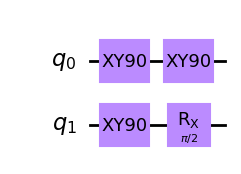

In [3]:
circuits_list[12][0].draw("mpl")
# plt.show()

In [4]:
idx = 0
print("seqs: %s, depths: %s" %(seqs, depths))
for s in range(seqs):
    for id, d in enumerate(depths):
        print("circuit of seqs-%s, depths-%s:\n %s" %(s+1, d, circuits_list[s][id]))
        for d_ in range(d):
            print(f"cycle-{d_+1}")
            print(f"a1:\n [[{a1_00[idx]}, {a1_01[idx]}], [{a1_10[idx]}, {a1_11[idx]}]]")
            print(f"a2:\n [[{a2_00[idx]}, {a2_01[idx]}], [{a2_10[idx]}, {a2_11[idx]}]]")
            idx += 1

# Plot the results
def create_subplot(data, subplot_number, title):
    print(title)
    print("data: %s" % data)
    print(subplot_number)
    plt.subplot(subplot_number)
    plt.pcolor(depths, range(seqs), np.abs(data))
    ax = plt.gca()
    ax.set_title(title)
    if subplot_number > 244: ax.set_xlabel('Circuit depth')
    ax.set_ylabel('Sequences')
    ax.set_xticks(depths)
    ax.set_yticks(np.arange(1, seqs + 1))
    plt.colorbar()


titles = []
for i in range(4):
    titles.append(f"<{bin(i)[2:].zfill(2)}> Measured")
    titles.append(f"<{bin(i)[2:].zfill(2)}> Expected")

# data = [S1, S2, I1, I2]
data = []
for i in range(4):
    data.append(measured_probs[:, :, i])
    data.append(expected_probs[:, :, i])

plot_number = [241, 242, 243, 244, 245, 246, 247, 248]


seqs: 301, depths: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
circuit of seqs-1, depths-1:
      ┌──────┐┌─────────┐
q_0: ┤ XY90 ├┤ Ry(π/2) ├
     ├──────┤├─────────┤
q_1: ┤ XY90 ├┤ Ry(π/2) ├
     └──────┘└─────────┘
cycle-1
a1:
 [[0.0, 1.0], [-1.0, 0.0]]
a2:
 [[0.0, 1.0], [-1.0, 0.0]]
circuit of seqs-1, depths-2:
      ┌──────┐┌─────────┐┌──────┐
q_0: ┤ XY90 ├┤ Rx(π/2) ├┤ XY90 ├
     ├──────┤├─────────┤├──────┤
q_1: ┤ XY90 ├┤ Ry(π/2) ├┤ XY90 ├
     └──────┘└─────────┘└──────┘
cycle-1
a1:
 [[1.0, 0.0], [0.0, 1.0]]
a2:
 [[0.0, 1.0], [-1.0, 0.0]]
cycle-2
a1:
 [[0.7071067802608013, 0.7071067802608013], [-0.7071067802608013, 0.7071067802608013]]
a2:
 [[0.7071067802608013, 0.7071067802608013], [-0.7071067802608013, 0.7071067802608013]]
circuit of seqs-1, depths-3:
      ┌──────┐┌─────────┐  ┌──────┐ ┌─────────┐
q_0: ┤ XY90 ├┤ Rx(π/2) ├──┤ XY90 ├─┤ Rx(π/2) ├
     ├──────┤├─────────┤┌─┴──────┴┐└─┬──────┬┘
q_1: ┤ XY90 ├┤ Rx(π/2) ├┤ Ry(π/2) ├──┤ XY90 ├─
     └──────┘└─────────┘└─────────┘  └──

<00> Measured
data: [[0.03508772 0.03508772 0.38596491 ... 0.         0.15789474 0.24561404]
 [0.03508772 0.03508772 0.31578947 ... 0.15789474 0.15789474 0.38596491]
 [0.03508772 0.03508772 0.26315789 ... 0.19298246 0.31578947 0.12280702]
 ...
 [0.01754386 0.12280702 0.15789474 ... 0.01754386 0.24561404 0.36842105]
 [0.01754386 0.01754386 0.33333333 ... 0.14035088 0.05263158 0.1754386 ]
 [0.03508772 0.03508772 0.24561404 ... 0.22807018 0.26315789 0.07017544]]
241
<00> Expected
data: [[0.02778 0.00309 0.36111 ... 0.05544 0.10259 0.29127]
 [0.01852 0.0463  0.26852 ... 0.23384 0.02915 0.58934]
 [0.01852 0.00926 0.25    ... 0.22852 0.55727 0.08487]
 ...
 [0.02778 0.0463  0.24074 ... 0.13992 0.06424 0.90947]
 [0.01235 0.02778 0.25    ... 0.00663 0.02229 0.28372]
 [0.02778 0.00926 0.26852 ... 0.57659 0.13374 0.01235]]
242
<01> Measured
data: [[0.19298246 0.15789474 0.42105263 ... 0.05263158 0.40350877 0.35087719]
 [0.12280702 0.22807018 0.42105263 ... 0.10526316 0.1754386  0.36842105]
 [0.08

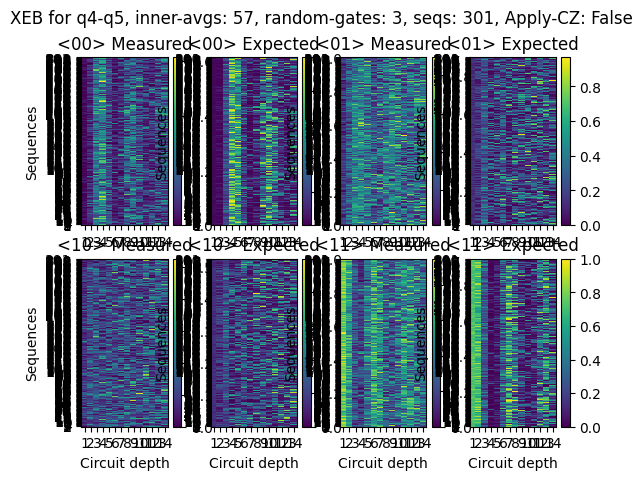

In [9]:
plt.suptitle(f"XEB for q{qubits[0]}-q{qubits[1]}, inner-avgs: {avgs}, random-gates: {random_gates}, seqs: {seqs}, Apply-CZ: {apply_cz}")
for title, d, n in zip(titles, data, plot_number):
    create_subplot(d, n, title)

Fxeb = np.mean(fidelities, axis=0)
print(Fxeb)

def exponential_decay(x, a, b, c):
    return a * np.exp(-b * x) + c


try:
    params, covariance = curve_fit(exponential_decay, depths, Fxeb)
    a_fit, b_fit, c_fit = params
    x = exponential_decay(depths, a_fit, b_fit, c_fit)
    xeb_err_per_cycle = 1 - (x[2] - c_fit) / (x[1] - c_fit)
except:
    pass
    


fit failed


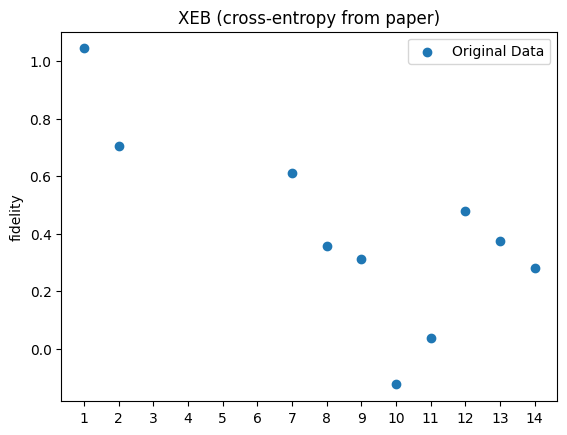

In [11]:
plt.scatter(depths, Fxeb, label='Original Data')
# plt.plot(np.arange(depth), exponential_decay(np.arange(depth), a_fit, b_fit, c_fit), label='err_per_cycle={:.2f}'.format(xeb_err_per_cycle), color='red')
plt.legend()
plt.title("XEB (cross-entropy from paper)")
plt.ylabel("fidelity")
plt.xticks(depths)
# plt.show()

# Google Quantum AI notebook post processing
df = pd.DataFrame(records)
df["y"] = df["m_u"] - df["u_u"]
df["x"] = df["e_u"] - df["u_u"]

df["numerator"] = df["x"] * df["y"]
df["denominator"] = df["x"] ** 2
df.head()

# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    params, covariance = curve_fit(exponential_decay, depths, Fxeb)
    a_fit, b_fit, c_fit = params
    x = exponential_decay(depths, a_fit, b_fit, c_fit)
    xeb_err_per_cycle = 1 - (x[2] - c_fit) / (x[1] - c_fit)
    xx = np.linspace(0, df["x"].max())
    
    # plt.figure()
    plt.plot(xx, exponential_decay(xx, a_fit, b_fit, c_fit),
            label='Least Squares fit, err_per_cycle={:.2f}'.format(xeb_err_per_cycle),
            color='red')

except:
    # pass
    print("fit failed")

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).


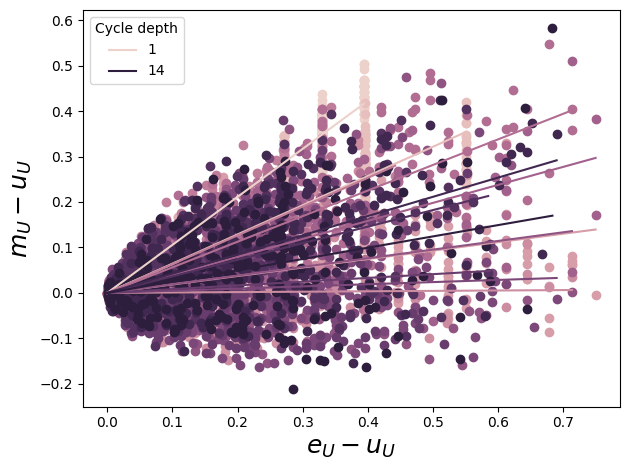

In [7]:
colors = sns.cubehelix_palette(n_colors=len(depths))
colors = {k: colors[i] for i, k in enumerate(depths)}

_lines = []


def per_cycle_depth(df):
    fid_lsq = df["numerator"].sum() / df["denominator"].sum()

    cycle_depth = df.name
    xx = np.linspace(0, df["x"].max())
    (l,) = plt.plot(xx, fid_lsq * xx, color=colors[cycle_depth])
    plt.scatter(df["x"], df["y"], color=colors[cycle_depth])

    global _lines
    _lines += [l]  # for legend
    return pd.Series({"fidelity": fid_lsq})


fids = df.groupby("depth").apply(per_cycle_depth).reset_index()
plt.xlabel(r"$e_U - u_U$", fontsize=18)
plt.ylabel(r"$m_U - u_U$", fontsize=18)
_lines = np.asarray(_lines)
plt.legend(_lines[[0, -1]], depths[[0, -1]], loc="best", title="Cycle depth")
plt.tight_layout()


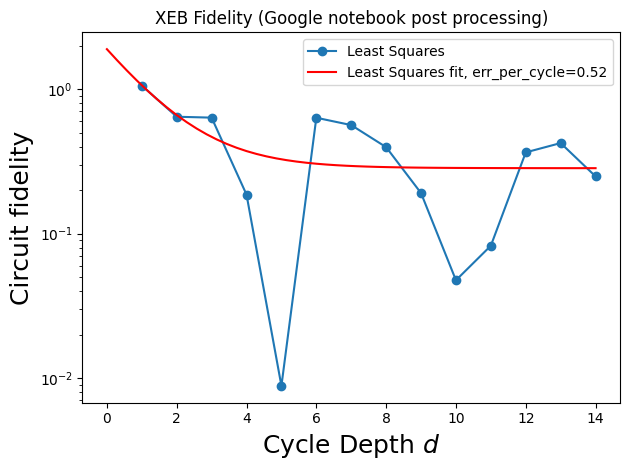

0     1.056299
1     0.642867
2     0.633691
3     0.185933
4     0.008824
5     0.632625
6     0.562800
7     0.395931
8     0.190446
9     0.047497
10    0.082354
11    0.364319
12    0.422635
13    0.248498
Name: fidelity, dtype: float64


In [8]:

plt.plot(fids["depth"], fids["fidelity"], marker="o", label="Least Squares")
xx = np.linspace(0, fids["depth"].max())

# In XEB, we extract the depolarizing fidelity, which is
# related to (but not equal to) the Pauli error.
# For the latter, an error involves doing X, Y, or Z with E_PAULI/3
# but for the former, an error involves doing I, X, Y, or Z with e_depol/4
try:
    params, covariance = curve_fit(exponential_decay, depths, fids["fidelity"])
    a_fit, b_fit, c_fit = params
    x = exponential_decay(depths, a_fit, b_fit, c_fit)
    xeb_err_per_cycle = 1 - (x[2] - c_fit) / (x[1] - c_fit)
    
    # plt.figure()
    plt.plot(xx, exponential_decay(xx, a_fit, b_fit, c_fit),
            label='Least Squares fit, err_per_cycle={:.2f}'.format(xeb_err_per_cycle),
            color='red')

    plt.ylabel("Circuit fidelity", fontsize=18)
    plt.xlabel("Cycle Depth $d$", fontsize=18)
    plt.title("XEB Fidelity (Google notebook post processing)")
    plt.legend(loc="best")
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

except:
    pass

# The additional factor of four in the exponent is because each layer
# involves two moments of two qubits (so each layer has four applications
# of a single-qubit single-moment depolarizing channel).
print(fids["fidelity"])


